In [1]:
# Import the libraries

# Data manipulation
import numpy as np
import pandas as pd

# For statistical analysis
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA

# Import matplotlib and set the style
import matplotlib.pyplot as plt


# Import and filter warnings
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)


# Read the csv file using read_csv method of pandas
data = pd.read_csv("wheat_etf_price_2011_2020.csv", index_col=0)
data.index = pd.to_datetime(data.index)

# Drop the missing values
data = data.dropna()

# Rolling Window
rolling_window = int(len(data)*0.70)

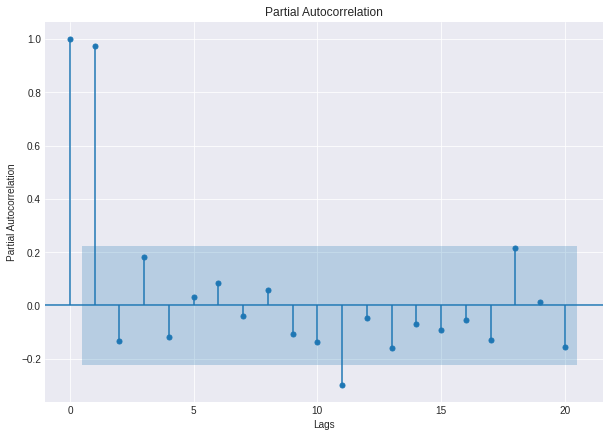

In [2]:
fig, ax = plt.subplots(figsize=(10, 7))
plot_pacf(data['Adj Close'][:rolling_window], lags=20, ax=ax)
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [3]:
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)

# Train autoregressive model of order 11
model_fit = ARIMA(data['Adj Close'][:rolling_window], (11, 0, 0)).fit()
print(model_fit.params.round(2))

const               13.89
ar.L1.Adj Close      1.13
ar.L2.Adj Close     -0.29
ar.L3.Adj Close      0.14
ar.L4.Adj Close      0.08
ar.L5.Adj Close     -0.23
ar.L6.Adj Close      0.36
ar.L7.Adj Close     -0.18
ar.L8.Adj Close      0.05
ar.L9.Adj Close     -0.02
ar.L10.Adj Close     0.13
ar.L11.Adj Close    -0.15
dtype: float64


In [4]:
# Function to predict the price of 1 day
def predict_price_AR(train_data):
    # Define model
    model = ARIMA(train_data,order=(11, 0, 0))
    
    # Fit the model
    model_fit = model.fit(disp=0)  
    
    # Make forecast
    forecast_results = model_fit.forecast()  
    
    return forecast_results[0][0]

In [5]:
# This cell will predict the values of the series and it is possible it will take time to run.

# Predict the price using 'predict_price_AR' function
data['predicted_price'] = data['Adj Close'].rolling(rolling_window).apply(predict_price_AR)
# Shift the predicted price by 1 period
data['predicted_price'] = data['predicted_price'].shift(1)
data.round(2).tail()

,Open,High,Low,Close,Adj Close,Volume,predicted_price
Date,,,,,,,
2020-07-01,5.09,5.52,5.01,5.41,5.41,3131400,5.46
2020-08-01,5.37,5.59,5.02,5.52,5.52,6008300,5.33
2020-09-01,5.55,5.79,5.36,5.71,5.71,6034600,5.61
2020-10-01,5.72,6.16,5.59,5.81,5.81,10575700,5.64
2020-11-01,5.79,5.92,5.78,5.90,5.90,670700,5.77


The Mean Absolute Error is 0.31
The Mean Squared Error is 0.13
The Root Mean Squared Error is 0.37
The Mean Absolute Percentage Error is 5.30


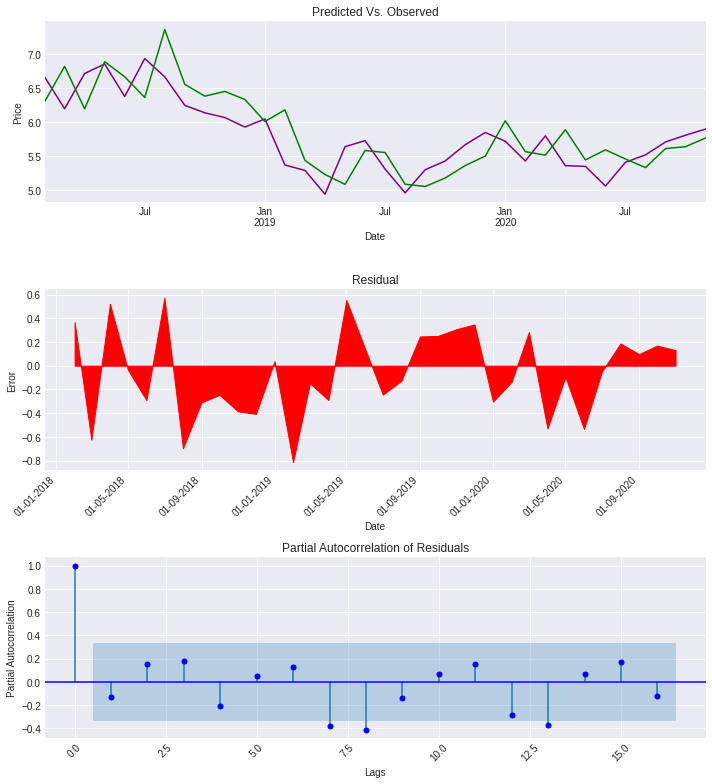

In [6]:
# Import model_performance
from xyz_function_file import model_performance

# Call `model_performance` to evaluate the performance of the model
model_performance(data['Adj Close'].iloc[rolling_window:], data['predicted_price'].iloc[rolling_window:])

In [7]:
data['wheat_returns'] = data['Adj Close'].pct_change()
# Create signal
data['signal'] = np.where(data.predicted_price.shift(1) < data.predicted_price, 1, -1)
data['strategy_returns'] = data.signal.shift(1) * data.wheat_returns
data.tail()

,Open,High,Low,Close,Adj Close,Volume,predicted_price,wheat_returns,signal,strategy_returns
Date,,,,,,,,,,
2020-07-01,5.09,5.52,5.01,5.41,5.41,3131400,5.458859,0.069170,-1,0.069170
2020-08-01,5.37,5.59,5.02,5.52,5.52,6008300,5.332564,0.020333,-1,-0.020333
2020-09-01,5.55,5.79,5.36,5.71,5.71,6034600,5.612548,0.034420,1,-0.034420
2020-10-01,5.72,6.16,5.59,5.81,5.81,10575700,5.640398,0.017513,1,0.017513
2020-11-01,5.79,5.92,5.78,5.90,5.90,670700,5.768904,0.015491,1,0.015491


The Sharpe Ratio is -0.81
The cumulative return is -14.75%
The maximum drawdown is -34.25%


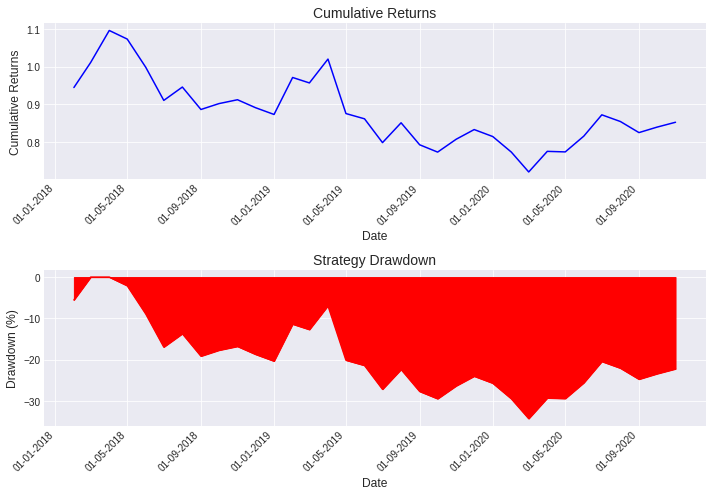

In [8]:
# Import analyse_startegy
from xyz_function_file import analyse_strategy

# Call `analyse_strategy` 
analyse_strategy(data['strategy_returns'].iloc[rolling_window:])